<a href="https://colab.research.google.com/github/akirakudo901/Joystick-Prediction/blob/main/Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECoG Dataset

## Downloading the Dataset

In [30]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
import os, requests
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from scipy import signal
import matplotlib.animation as animation
import math

In [31]:
fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [32]:
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Dataset info


This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 4 sessions from 4 subjects, and was used in these papers:

- Schalk, G., et al. "Decoding two-dimensional movement trajectories using electrocorticographic signals in humans." Journal of Neural Engineering 4.3 (2007): 264. doi: [10.1088/1741-2560/4/3/012](https://doi.org/10.1088/1741-2560/4/3/012)

- Schalk, Gerwin, et al. "Two-dimensional movement control using electrocorticographic signals in humans." Journal of Neural Engineering 5.1 (2008): 75. doi: [10.1088/1741-2560/5/1/008](https://doi.org/10.1088/1741-2560/5/1/008)

<br>

From the dataset readme:

*During the study, each patient was in a semi-recumbent position in a hospital bed about 1 m from a computer monitor. The patient used a joystick to maneuver a white cursor track a green target moving counter-clockwise in a circle of diameter 85% of monitor height ~1m away. The hand used to control the joystick was contralateral to the implanted electrode array.*

<br>

We also know that subject 0 was implanted in the left temporal lobe, while subject 2 was implanted in the right frontal lobe.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size.

Variables are:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['targetX']`: position of the target on the screen
* `dat['targetY']`: position of the target on the screen
* `dat['cursorX']`: X position of the cursor controlled by the joystick
* `dat['cursorY']`: X position of the cursor controlled by the joystick
* `dat['locs`]: three-dimensional coordinates of the electrodes

### Data Loading

In [33]:
# DEFINING USEFUL CONSTANTS
SAMPLE_RATE = 1000
# By checking cursor sample rate in "Identifying sample ..." below, we figured
# the sample rate of cursor on screen was identified every 40 time points
TIMEPOINTS_PER_CURSOR_UPDATE = 40

Shape of alldat: (1, 4)
dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
Shape of V: (372760, 60)
Shape of targetX: (372760, 1)
Shape of targetY: (372760, 1)
Shape of cursorX: (372760, 1)
Shape of cursorY: (372760, 1)


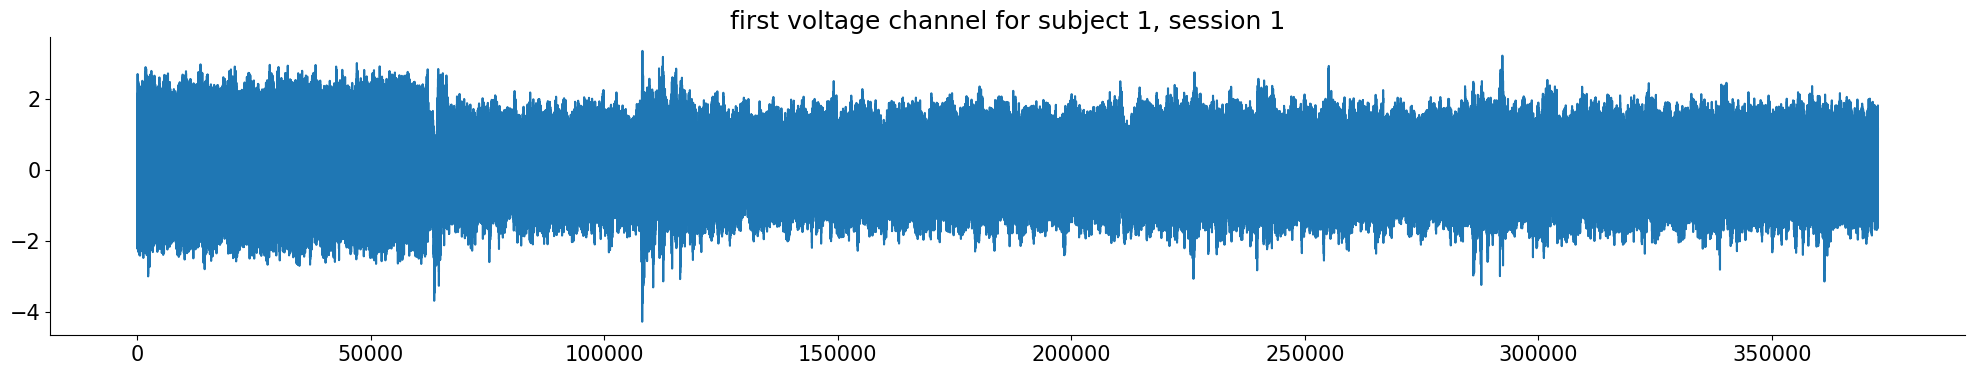

In [34]:
alldat = np.load(fname, allow_pickle=True)['dat']
print("Shape of alldat:", alldat.shape)

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]
print(dat.keys())
print("Shape of V:", dat['V'].shape)
print("Shape of targetX:", dat['targetX'].shape)
print("Shape of targetY:", dat['targetY'].shape)
print("Shape of cursorX:", dat['cursorX'].shape)
print("Shape of cursorY:", dat['cursorY'].shape)

plt.plot(dat['V'][:, 0])
plt.title("first voltage channel for subject 1, session 1")
plt.show()

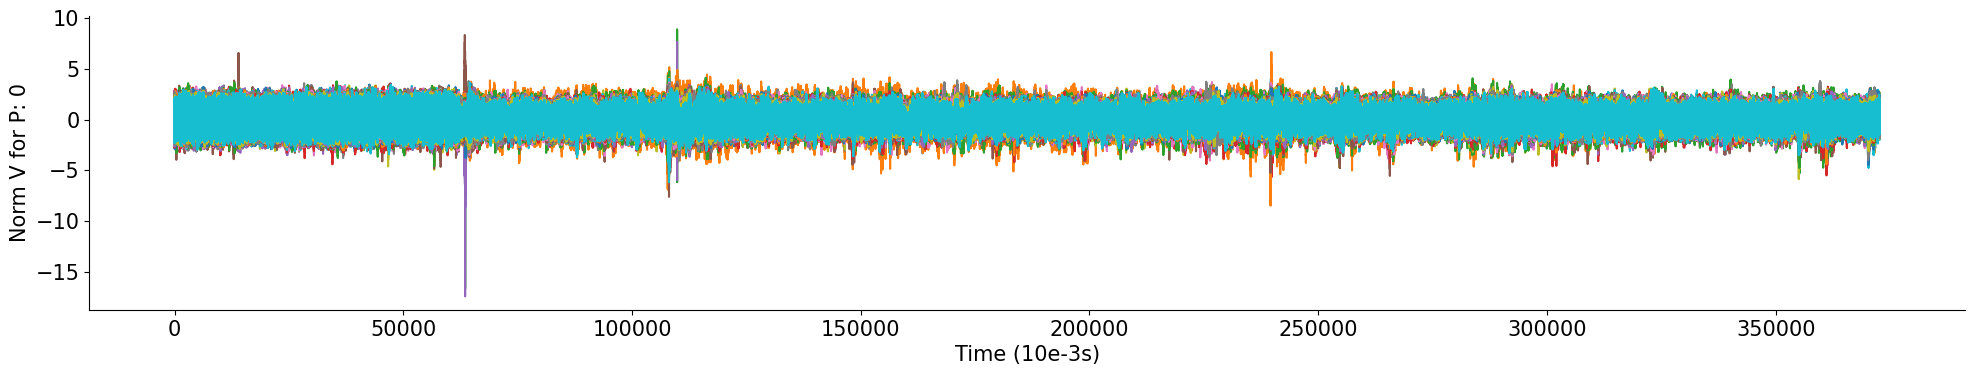

In [35]:
PATIENT_NUMBER = 0

dat = alldat[0][PATIENT_NUMBER]
V = dat['V'].astype('float16')

nt, nchan = V.shape

plt.plot(V)
plt.xlabel('Time (10e-3s)')
plt.ylabel(f'Norm V for P: {PATIENT_NUMBER}')

plt.show()

In [36]:
def datatype_per_patient(patient_num):
  print(f"PATIENT {i}")
  patient = alldat[0][patient_num]
  printed = " ".join(
      [f"({k} : {patient[k].dtype})" if isinstance(patient[k], np.ndarray) else ""
      for k in patient.keys()])
  print(printed)


print("DATATYPE:")
for i in range(len(alldat[0])):
  datatype_per_patient(i)

DATATYPE:
PATIENT 0
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    
PATIENT 1
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    
PATIENT 2
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    
PATIENT 3
(V : float16) (targetX : uint16) (targetY : uint16) (cursorX : uint16) (cursorY : uint16) (locs : float64)    


In [37]:
def description_for_patient_i(i):
  print(f"FOR PATIENT {i}:")
  patient = alldat[0][i]

  assert(patient['V'].shape[0]       == patient['targetX'].shape[0] and
         patient['targetX'].shape[0] == patient['targetY'].shape[0] and
         patient['targetY'].shape[0] == patient['cursorX'].shape[0] and
         patient['cursorX'].shape[0] == patient['cursorY'].shape[0])

  assert(patient['targetX'].shape[1] == 1 and
         patient['targetY'].shape[1] == 1 and
         patient['cursorX'].shape[1] == 1 and
         patient['cursorY'].shape[1] == 1)

  assert(patient['V'].shape[1] == patient['locs'].shape[0])

  num_timepoints, num_channels = patient['V'].shape
  print(f" - Voltage data has {num_timepoints} timepoints and {num_channels} channels.")

  print(f" - Locations of {num_channels} electrodes expressed in {patient['locs'].shape[1]}D.")

  for category_label in ['hemisphere', 'lobe', 'gyrus', 'Brodmann_Area']:
    unique_labels = np.unique(patient[category_label])
    print(f" - Unique labels for {category_label}: \n{unique_labels}.")

  print("___________________________________")


num_patients = len(alldat[0])
# print(f"We have {num_patients} patients in this dataset.")

for i in range(num_patients):
  description_for_patient_i(i)

FOR PATIENT 0:
 - Voltage data has 372760 timepoints and 60 channels.
 - Locations of 60 electrodes expressed in 3D.
 - Unique labels for hemisphere: 
['Left Cerebrum'].
 - Unique labels for lobe: 
['Frontal Lobe' 'Parietal Lobe' 'Temporal Lobe'].
 - Unique labels for gyrus: 
['Inferior Frontal Gyrus' 'Middle Frontal Gyrus' 'Middle Temporal Gyrus'
 'Postcentral Gyrus' 'Precentral Gyrus' 'Superior Frontal Gyrus'
 'Superior Temporal Gyrus'].
 - Unique labels for Brodmann_Area: 
['Brodmann area 10' 'Brodmann area 2' 'Brodmann area 21'
 'Brodmann area 22' 'Brodmann area 3' 'Brodmann area 38' 'Brodmann area 4'
 'Brodmann area 40' 'Brodmann area 42' 'Brodmann area 43'
 'Brodmann area 44' 'Brodmann area 45' 'Brodmann area 46'
 'Brodmann area 47' 'Brodmann area 6' 'Brodmann area 8' 'Brodmann area 9'].
___________________________________
FOR PATIENT 1:
 - Voltage data has 248640 timepoints and 64 channels.
 - Locations of 64 electrodes expressed in 3D.
 - Unique labels for hemisphere: 
['Right 

In [38]:
# Given the cursor movement sample rates seems lower than 1000Hz,
# identify sample rate for cursor movement

# first define useful functions
# Counts the number of consecutive true / false blocks
def count_consecutive_true_or_false_block_sizes(arr, countTrue):
  # find positions where a new block begins
  block_start = np.concatenate(([True], arr[:-1] != arr[1:]))
  # get block lengths based on that
  block_lengths = np.diff(
      np.append( np.where(block_start)[0], len(arr))
      )
  # count block sizes of interest
  count_start = 0 if (countTrue == arr[0]) else 1
  counting_block_sizes = block_lengths[count_start::2]
  return counting_block_sizes

def SanityCheck_count_consecutive_true_or_false_block_sizes():
  block_sizes = [3,2,5,1,20,3]; initial_val = False
  initial_val_blocks = [3,5,20]; opposite_val_blocks = [2,1,3]
  arr = np.concatenate(
      [np.array([i % 2 != 0] * block_sizes[i])
      for i in range(0, len(block_sizes))]
  )
  np.testing.assert_array_equal(opposite_val_blocks,
      count_consecutive_true_or_false_block_sizes(arr, not initial_val))
  np.testing.assert_array_equal(initial_val_blocks,
      count_consecutive_true_or_false_block_sizes(arr, initial_val))

SanityCheck_count_consecutive_true_or_false_block_sizes()

# then use it
def check_window_sizes(patient_num):
  print(f"PATIENT {patient_num}: ")
  def check_for_window_size_given_one_array(arr):
    # indices at which values are different from immediate previous
    # * 1st entry is considered different
    block_starts = np.insert(np.ediff1d(arr).astype(bool), 0, True)

    likely_window_sizes = count_consecutive_true_or_false_block_sizes(block_starts, False) + 1
    unique_window_sizes = np.unique(likely_window_sizes)
    print("Unchanging window sizes found: \n", unique_window_sizes)
    # at this point, we can see that values are all multiples of 40
    assert np.prod(np.mod(unique_window_sizes, 40) == 0) == 1, \
           f"Some window size for patient {patient_num} isn't a multiple of 40: " + \
           f"{arr}."

  cursorX = alldat[0][patient_num]["cursorX"]
  cursorY = alldat[0][patient_num]["cursorY"]

  check_for_window_size_given_one_array(cursorX)
  check_for_window_size_given_one_array(cursorY)

for patient_num in range(len(alldat[0])):
  check_window_sizes(patient_num)

PATIENT 0: 
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  360  400  440  480  520  560
  600  640  680  720  800  840  880  920 1040 1160 1200 1280 1440 2080
 2120]
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  360  400  440  480  520  600
  640  680  760  800  840 1080 1200 2080 2120 2200]
PATIENT 1: 
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  360  400  440  480  520  600  640
  720  760  800  840  880  920 1000 1040 1120 1200 1360 1720 1800 2080]
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  360  400  440  480  520  560
  600  640  720  760  920 1040 1080 1120 1200 1240 1440 1480 1520 1720
 2080]
PATIENT 2: 
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  400  480  520  600  680 1040
 1160 1200 1320 1360 1440 1560 1840 1960 2040 2080 2320 4040]
Unchanging window sizes found: 
 [  40   80  120  160  200  240  280  320  400  440  480  520  680  80

## Dataset Visualization

### Joystick Data

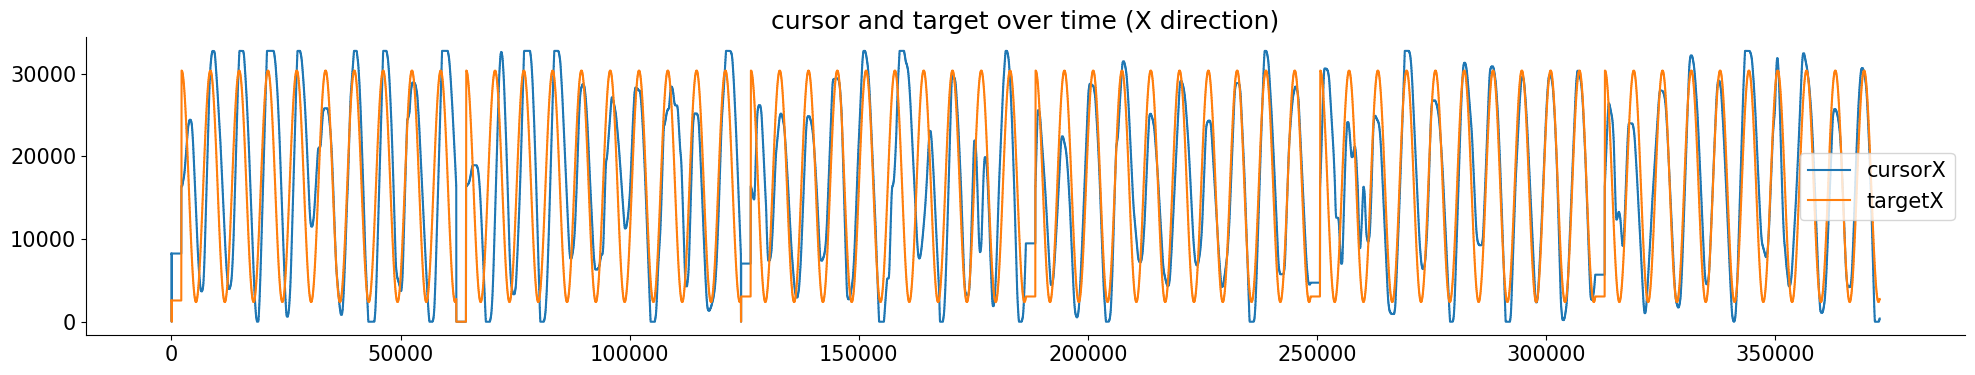

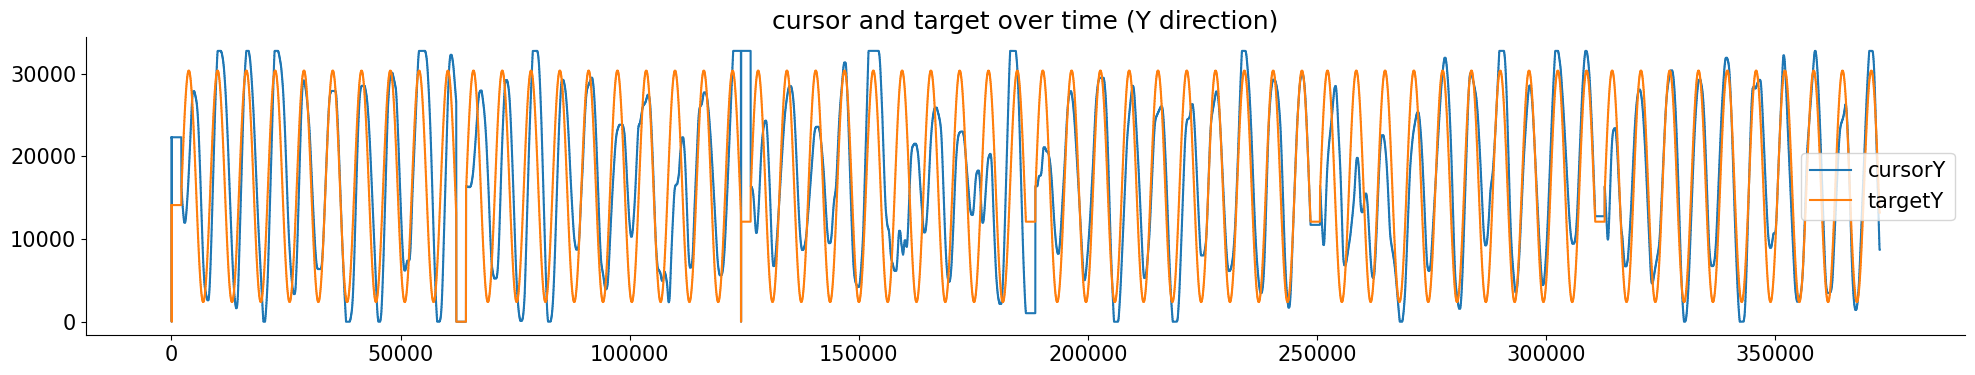

In [39]:
# plot cursor data
dat = alldat[0][0]

plt.figure(1)
plt.plot(dat['cursorX'], label='cursorX')
plt.plot(dat['targetX'], label='targetX')
plt.title('cursor and target over time (X direction)')
plt.legend()

plt.figure(2)
plt.plot(dat['cursorY'], label='cursorY')
plt.plot(dat['targetY'], label='targetY')
plt.title('cursor and target over time (Y direction)')
plt.legend()

plt.show()

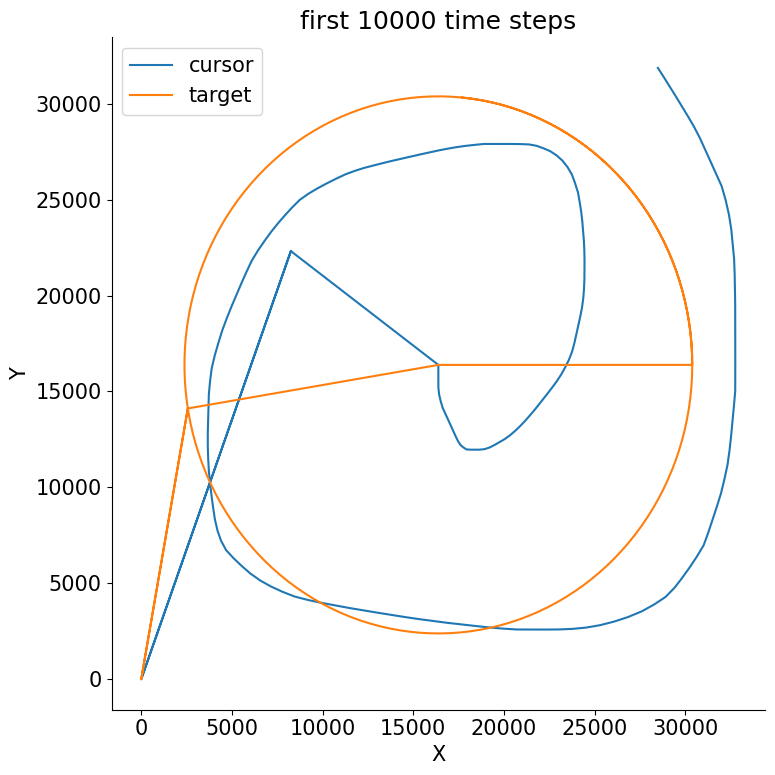

In [40]:
plt.figure(3, figsize=(8, 8))
plt.plot(dat['cursorX'][:10000], dat['cursorY'][:10000], label='cursor')
plt.plot(dat['targetX'][:10000], dat['targetY'][:10000], label='target')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('first 10000 time steps')
plt.legend()
plt.show()

In [41]:
CALCULATION_DATATYPE = np.float32

# Add labels based on X, Y directions of cursor at each point in time
# At each time point, the cursor position is simulated as:
# 1) direction as the direction from current position to next position
# 2) distance from center as speed between time points
# 2's definition is quite arbitrary - but we believe it is not an issue,
# given we only consider the overall stick direction 1 as label.
# Returns speed and direction (counter-clockwise starting from east direction
# in radians) between each time point
def get_speed_and_direction(cursorX : np.ndarray, cursorY : np.ndarray,
                            xLimits=( float("-inf"), float("inf")),
                            yLimits=( float("-inf"), float("inf"))):
  if type(xLimits) not in [type([]), type(())] or len(xLimits) != 2:
    print("xLimits must be a list/tuple with length 2; try again!")
    return
  elif type(yLimits) not in [type([]), type(())] or len(yLimits) != 2:
    print("yLimits must be a list/tuple with length 2; try again!")
    return
  else:
    xUpperbound = max(xLimits); xLowerbound = min(xLimits)
    yUpperbound = max(yLimits); yLowerbound = min(yLimits)

  cursorX = cursorX.astype(CALCULATION_DATATYPE)
  cursorY = cursorY.astype(CALCULATION_DATATYPE)
  # filter based on x/y limits
  cursorX[(cursorX > xUpperbound) | (cursorX < xLowerbound)] = np.nan
  cursorY[(cursorY > yUpperbound) | (cursorY < yLowerbound)] = np.nan
  # compute speed & direction between each time point
  diffX = np.ediff1d(cursorX); diffY = np.ediff1d(cursorY)
  speedSq = np.square(diffX) + np.square(diffY)
  speed = np.sqrt(speedSq)
  # direction
  direction = np.arctan2(diffY, diffX)
  direction = np.mod(direction + 2*np.pi, 2*np.pi) # 0 <= dir <= 2pi
  return speed, direction

def SanityCheck_get_speed_and_direction():
  # try 30, 45, 60, 120, 135, 150, 210, 225, 240, 300, 315 and 330 degrees
  PI = np.pi; angles = [  PI/6,   PI/4, 2*PI/6,  4*PI/6, 3*PI/4,  5*PI/6,
                        7*PI/6, 5*PI/4, 8*PI/6, 10*PI/6, 7*PI/4, 11*PI/6]
  # try 1, 2 and 3 speeds
  distances = [1,2,3]

  for angle in angles:
    for distance in distances:
      x = np.array([0, distance*np.cos(angle)]).astype(CALCULATION_DATATYPE)
      y = np.array([0, distance*np.sin(angle)]).astype(CALCULATION_DATATYPE)
      speed, direction = get_speed_and_direction(x, y)
      np.testing.assert_almost_equal(distance,  speed, decimal=5)
      np.testing.assert_almost_equal(angle, direction, decimal=5)

SanityCheck_get_speed_and_direction()

In [53]:
# Plots joy stick position over time, with points progressively increasing in
# shade darkness for later time points
def plot_figure_over_time(X : np.ndarray, Y : np.ndarray,
                          start : int, end : int, figureName : str):
  blueColor = plt.cm.Blues(np.linspace(0.1,1,(end-start)))
  fig,ax = plt.subplots(figsize=(6,6))
  for k in range(end - start):
    if k + 1 > len(X): break
    ax.plot(X[k:k+2], Y[k:k+2], color=blueColor[k])
  plt.xlabel('X'); plt.ylabel('Y')
  plt.title(figureName)
  plt.xlim(np.nanmin(X), np.nanmax(X)); plt.ylim(np.nanmin(Y), np.nanmax(Y))
  plt.show()

In [51]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

# Plots and saves a gif of the change of an object's X/Y position over time
# X/Y : List of plot data over time
# plot_every_n : Plot 1 every N values of the X, Y inputs.
# figurepath : path to saving for gif, including name and extension
# doSave : whether to save the gif
# addProgressBar : whether to add a "progress bar" rendering
def plot_and_save_gif(X, Y, plot_every_n : int, figurepath : str,
                      doSave : bool=True, addProgressBar : bool = True,
                      trail_length : int = None):

  xLowerbound, xUpperbound = np.nanmin(X), np.nanmax(X)
  yLowerbound, yUpperbound = np.nanmin(Y), np.nanmax(Y)
  # Calculate how often we plot
  number_of_rendered_frames = len(X) // plot_every_n
  # Create the figure and axes objects
  fig, ax = plt.subplots(figsize=(6,6))
  # Set the initial plot
  plt.title(f"{os.path.basename(figurepath)}")
  plt.xlim(xLowerbound, xUpperbound)
  plt.ylim(yLowerbound, yUpperbound)
  data = ax.plot(X[0], Y[0], animated=True)[0]

  # Set up progress bar
  if addProgressBar:
    progressBarXMin = -0.8; progressBarXMax = 0.8; progressBarY = -0.8

    progressBarMiddle = (progressBarXMax + progressBarXMin) / 2
    progressBar = ax.plot(progressBarXMin, progressBarY, animated=True)[0]
    progressBarX = [(progressBarXMax - progressBarXMin) / number_of_rendered_frames * x -
                    progressBarXMin
                    for x in range(number_of_rendered_frames)]

  def update(i):
      plot_up_to = min(i * plot_every_n, len(X))

      if trail_length is None:
        plot_from = 0
      else:
        plot_from = max(plot_up_to - trail_length, 0)

      data.set_data(X[plot_from:plot_up_to], Y[plot_from:plot_up_to])

      if addProgressBar:
        progressBar.set_data(progressBarX[:i], [progressBarY]*i)
        return (data, progressBar)
      else:
        return (data,)

  # Create the animation object
  animation_fig = animation.FuncAnimation(
      fig, update, frames=math.ceil(len(X) / plot_every_n), interval=30,
      blit=True, repeat_delay=10
      )

  # Show the animation
  plt.show()
  if doSave:
    animation_fig.save(figurepath)

In [44]:
# Plots and saves a gif of the change of the cursor and joystick X/Y position
# over time
# cursorX/cursorY : List of cursor plot data over time
# joystickX/joystickY : List of joystick plot data over time
# plot_every_n : Plot 1 every N values of the X, Y inputs.
# figurepath : path to saving for gif, including name and extension
# doSave : whether to save the gif
# addProgressBar : whether to add a "progress bar" rendering
def plot_and_save_cursor_and_joystick_gif(cursorX, cursorY, joystickX, joystickY,
                                          plot_every_n : int, figurepath : str,
                                          doSave : bool=True,
                                          addProgressBar : bool = True,
                                          trail_length : int = None):

  xCursorLowerbound, xCursorUpperbound = np.nanmin(cursorX), np.nanmax(cursorX)
  yCursorLowerbound, yCursorUpperbound = np.nanmin(cursorY), np.nanmax(cursorY)
  xJoystickLowerbound, xJoystickUpperbound = np.nanmin(joystickX), np.nanmax(joystickX)
  yJoystickLowerbound, yJoystickUpperbound = np.nanmin(joystickY), np.nanmax(joystickY)
  # Calculate how often we plot
  assert len(cursorX) == len(cursorY)
  assert len(joystickX) == len(joystickY)
  totalOriginalFrames = max(len(cursorX), len(joystickX))
  number_of_rendered_frames = totalOriginalFrames // plot_every_n
  # Create the figure and axes objects
  fig, (c_ax, j_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  plt.title(f"{os.path.basename(figurepath)}")
  # Set the initial cursor plot
  c_ax.set_xlim(xCursorLowerbound, xCursorUpperbound)
  c_ax.set_ylim(yCursorLowerbound, yCursorUpperbound)
  c_data = c_ax.plot(cursorX[0], cursorY[0], animated=True)[0]
  # Set the initial joystick plot
  j_ax.set_xlim(xJoystickLowerbound, xJoystickUpperbound)
  j_ax.set_ylim(yJoystickLowerbound, yJoystickUpperbound)
  j_data = j_ax.plot(joystickX[0], joystickY[0], animated=True)[0]

  # Set up progress bar
  if addProgressBar:
    progressBarXMin = -0.8; progressBarXMax = 0.8; progressBarY = -0.8
    progressBar = j_ax.plot(progressBarXMin, progressBarY, animated=True)[0]
    progressBarX = [(progressBarXMax - progressBarXMin) /
                    number_of_rendered_frames * x +
                    progressBarXMin
                    for x in range(number_of_rendered_frames)]

  def update(i):
      plot_up_to = min(i * plot_every_n, totalOriginalFrames)

      if trail_length is None:
        plot_from = 0
      else:
        plot_from = max(plot_up_to - trail_length, 0)

      c_data.set_data(  cursorX[plot_from:plot_up_to],   cursorY[plot_from:plot_up_to])
      j_data.set_data(joystickX[plot_from:plot_up_to], joystickY[plot_from:plot_up_to])
      if addProgressBar:
        progressBar.set_data(progressBarX[:i], [progressBarY]*i)
        return (c_data, j_data, progressBar)
      else:
        return (c_data, j_data)

  # Create the animation object
  animation_fig = animation.FuncAnimation(
      fig, update, frames=math.ceil(totalOriginalFrames / plot_every_n),
      interval=100, blit=True, repeat_delay=10
      )

  # Show the animation
  plt.show()
  if doSave:
    animation_fig.save(figurepath)

speed: [      nan       nan   0.      ... 770.7457  753.93634 731.3173 ]
direction: [      nan       nan 0.        ... 4.7968235 4.8749213 4.910589 ]
joystickX: [       nan        nan 0.         ... 0.06414809 0.12040081 0.14211227]
joystickY: [        nan         nan  0.         ... -0.7579314  -0.7342461
 -0.70760006]
np.nanmin(X):-0.757931649684906, np.nanmax(X):0.757931649684906
np.nanmin(Y):-0.7579314708709717, np.nanmax(Y):0.7579315304756165


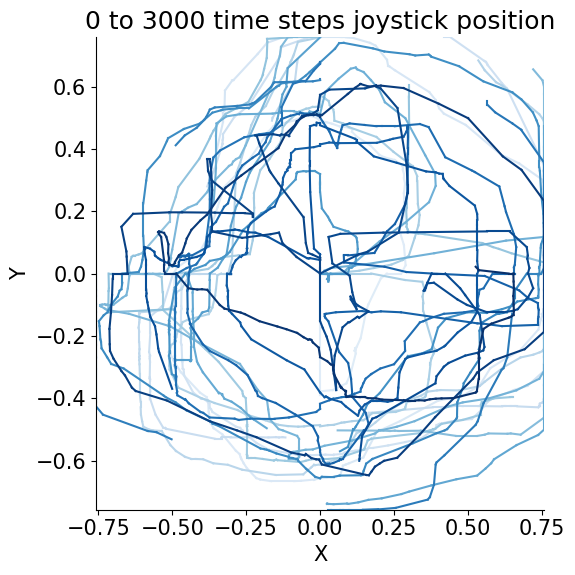

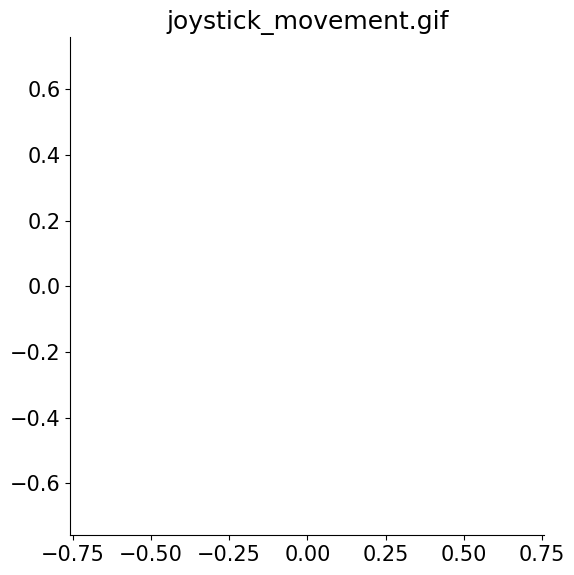

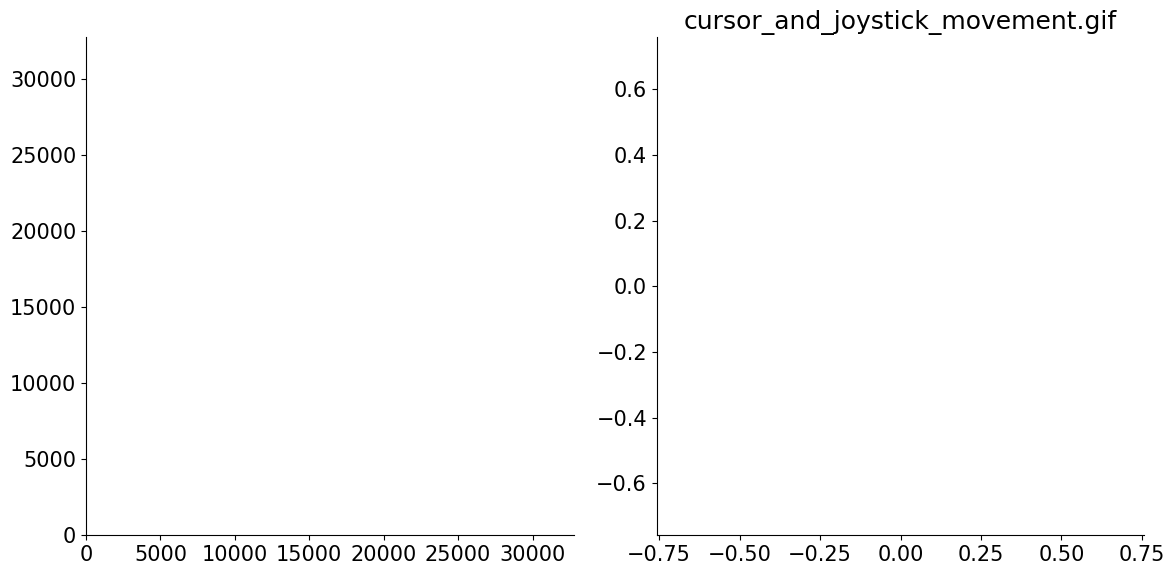

In [52]:
# Plot joystick and cursor position side by side

start = 0
end = start + 3000

patient = alldat[0][0]
cursorX = patient["cursorX"][::TIMEPOINTS_PER_CURSOR_UPDATE]
cursorY = patient["cursorY"][::TIMEPOINTS_PER_CURSOR_UPDATE]

ledgesX = (np.nanmin(cursorX)+1, np.nanmax(cursorX)-1)
ledgesY = (np.nanmin(cursorY)+1, np.nanmax(cursorY)-1)

speed, direction = get_speed_and_direction(
    cursorX, cursorY, xLimits=ledgesX, yLimits=ledgesY
    )
end = min(end, len(speed))
# TODO REMOVE
# ARBITRARY REMOVAL OF VALUES OF SPEED OVER 10000; THIS MAKES THE GRAPH MUCH
# MORE EASY TO UNDERSTAND
speed[speed > 10000] = 0
# TODO REMOVE END
norm_speed = speed / np.nanmax(speed) # normalize between 0 and 1

# plt.hist(speed)
# plt.yscale('log')
# plt.show

# compute position of joy stick from speed & direction
joystickX = norm_speed * np.cos(direction)
joystickY = norm_speed * np.sin(direction)

plot_figure_over_time(
    joystickX, joystickY, start, end,
    f'{start} to {min(end, len(joystickY))} time steps joystick position'
    )
# rendering only joystick
FIGURE_PATH = "joystick_movement.gif"
plot_and_save_gif(joystickX[start:end], joystickY[start:end],
                  plot_every_n=10, figurepath=FIGURE_PATH, doSave=True,
                  addProgressBar=True, trail_length=10*10)
# rendering both cursor and joystick
FIGURE_PATH = "cursor_and_joystick_movement.gif"
plot_and_save_cursor_and_joystick_gif(
      cursorX[start:end],   cursorY[start:end],
    joystickX[start:end], joystickY[start:end],
    plot_every_n=10, figurepath=FIGURE_PATH, doSave=True,
    addProgressBar=True, trail_length=10*10)

### ECoG Data